## Feature Engineering (Continued)
We continue working with the data we left off with from `EDA_1`. The primary focus of this script is to develop a novel feature from our data that correlates well with the price of the stock in the future.
<br>
<br>
**Importing required packages & changing working directory**

In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA, SparsePCA

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [30]:
stock_of_interest = "CVX"
stock_data_path = "data/EDA/"
adj_daily_closing_path = "data/adjusted_daily_closing/"
adj_daily_dividend_path = "data/dividends/"
eda_data_path = "data/EDA/"
lead_days = 5

**Load adjusted daily closing and dividend prices**

In [31]:
daily_closing = pd.read_csv(os.path.abspath(os.path.join(adj_daily_closing_path, (stock_of_interest + ".csv"))))
daily_closing["date"] = pd.to_datetime(daily_closing["date"]).dt.date

daily_dividend = pd.read_csv(os.path.abspath(os.path.join(adj_daily_dividend_path, (stock_of_interest + "_ts.csv"))))
daily_dividend["date"] = pd.to_datetime(daily_dividend["date"]).dt.date

adj_closing_df = daily_closing[["date", "close"]].merge(right=daily_dividend,
                                                        how="outer",
                                                        on="date")

adj_closing_df["adj closing"] = adj_closing_df["close"] - adj_closing_df["amount"]
adj_closing_df = adj_closing_df[["date", "adj closing"]]

**Load data file saved from `EDA_1.ipynb`**

In [32]:
calls_interest = pd.read_csv(os.path.abspath(os.path.join(eda_data_path, (stock_of_interest + "_calls_EDA1.csv"))))
calls_interest["date"] = pd.to_datetime(calls_interest["date"]).dt.date
calls_interest["expiration date"] = pd.to_datetime(calls_interest["expiration date"]).dt.date

puts_interest = pd.read_csv(os.path.abspath(os.path.join(eda_data_path, (stock_of_interest + "_puts_EDA1.csv"))))
puts_interest["date"] = pd.to_datetime(puts_interest["date"]).dt.date
puts_interest["expiration date"] = pd.to_datetime(puts_interest["expiration date"]).dt.date

**Here we attempt to create a meaningful feature based off our data**

We chose to multiply the change in interest, the price of the option, as well as the amount the stock needs to move were the option to expire exactly at the "breakeven" price. We feel that each of these three features are tied to each other. For example, the price of an option does not matter if there is no change in open interest. The listed "price" can happen to be very old or simply a ridiculous offer.

In [33]:
adj_closing = calls_interest.groupby(["date"]).mean()[["adj closing"]].reset_index()

calls_interest["calls senti"] = calls_interest["delta interest"] * calls_interest["price"] * calls_interest["auto delta price"]
calls_interest["calls senti day"] = calls_interest["calls senti"] / calls_interest["days till exp"]
calls_interest_day_exp = calls_interest.groupby(["date", "days till exp"]).sum()[["calls senti day"]].reset_index()

puts_interest["puts senti"] = puts_interest["delta interest"] * puts_interest["price"] * puts_interest["auto delta price"]
puts_interest["puts senti day"] = puts_interest["puts senti"] / puts_interest["days till exp"]
puts_interest_day_exp = puts_interest.groupby(["date", "days till exp"]).sum()[["puts senti day"]].reset_index()


In [34]:
# Merging calls and puts
options_senti = calls_interest_day_exp.merge(right = puts_interest_day_exp,
                                             how="outer",
                                             on = ["date", "days till exp"])

# Fill NaN sentiment values with 0
options_senti = options_senti.fillna(value=0)

options_senti["combined senti day"] = options_senti["calls senti day"] + options_senti["puts senti day"]

# Appending on several extra days in the future
end_index = int(adj_closing_df[adj_closing_df["date"] == adj_closing.iloc[-1]["date"]].index.values)
lead_append = adj_closing_df.iloc[end_index  + 1: (end_index  + lead_days + 1)]
adj_closing_ext = adj_closing.append(lead_append, ignore_index = True)

Adding change to closing price for several days after the last day in options data.

In [35]:
for n in range(1, 6):
    adj_closing_ext[str("lead " + str(n))] = adj_closing_ext["adj closing"].shift(periods=-n) - adj_closing_ext["adj closing"]

options_senti = options_senti.merge(right = adj_closing_ext,
                                    how = "left",
                                    on = "date")

**Visual Representation of Engineered Feature**

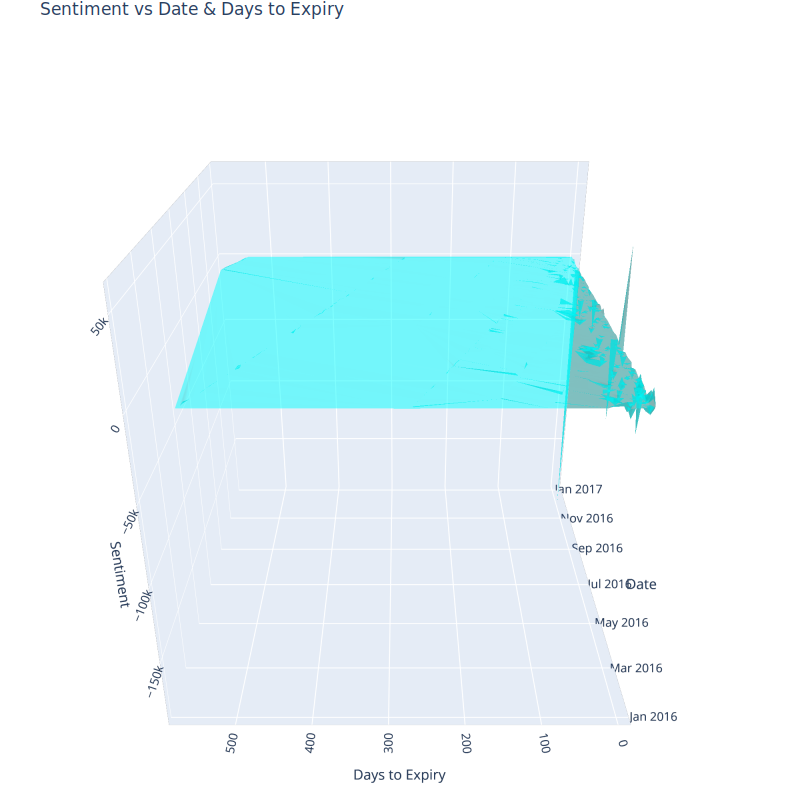

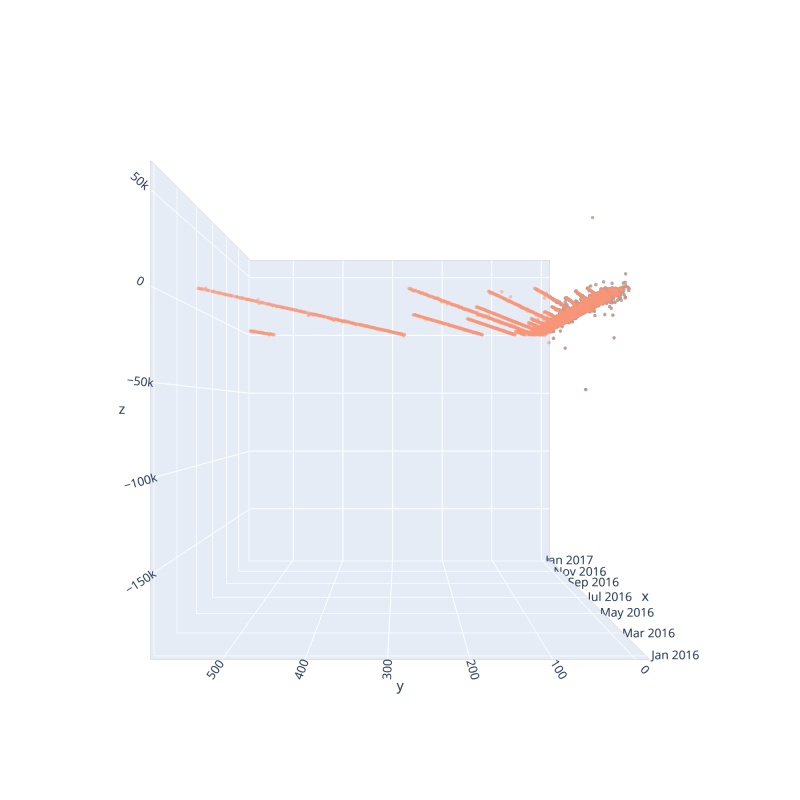

In [36]:
fig = go.Figure(data=[go.Mesh3d(x=options_senti["date"],
                                y=options_senti["days till exp"],
                                z=options_senti["combined senti day"],
                                opacity=0.5,
                                color="cyan")])

fig1 = go.Figure(data=[go.Scatter3d(
    x=options_senti["date"],
    y=options_senti["days till exp"],
    z=options_senti["combined senti day"],
    mode='markers',
    marker=dict(
        size=2,
        color=options_senti["combined senti day"],
        opacity=0.5,
        colorscale="agsunset",
        showscale=False
    )
)])

fig.update_layout(scene = dict(
    xaxis_title="Date",
    yaxis_title="Days to Expiry",
    zaxis_title='Sentiment'),
    margin=dict(t=30, r=0, l=0, b=0),
    font=dict(size=12),
    scene_camera=dict(eye=dict(x=-2, y=0, z=1)),
    title="Sentiment vs Date & Days to Expiry")

fig1.update_layout(font=dict(size=12),
                   scene_camera=dict(eye=dict(x=-2, y=0, z=0)))

fig.show("svg", width=800, height=800)
fig1.show("svg", width=800, height=800)# fig.show("svg", width=900, height=600)

**Observations**

From looking at the call and put option "sentiment" as seen above, we see that there are "spikes" in sentiment. Many of these spikes are caused by call exercises that happened shortly before ex-dividend dates. In the example of `CVX`, there were spikes on 04-28, 05-16, 08-16 and 11-15. The ex-dividend dates were 02-16, 05-17, 08-17 and 11-16 of that year. This happens with stocks that are dividend heavy, as in the case with `CVX`.

Future improvement: Remove all options where obvious exercising took place. Note that extreme values of sentiment do not necessarily indicate exercise. Extremely negative values of call sentiment immediately before ex-div dates, or positive put sentiment immediately on/after ex-div dates could imply exercise.

**Feature Binning**

Ultimately, we want to create a model that uses the sentiment value of each day as a unique feature. For instance, the sentiment for 1 day till expiry is one feature, 2 days till expiry being another feature ...etc. However, we realize that, given that almost all options expire on the Friday of each week, and with the furthest option being more than 2 years out in some cases, there are simply too many features. There would be roughly over 600 features, with all except roughly 10 of those being 0's on a given day. In addition, most features would only have a handful of observations with non-trivial entries. This can be seen by the sparse diagonal lines above.

I will first categorize the days till expiry by virtue of how many weeks are left. For example, I will consider 1 to 5 days till expiry as feature 1, 6 to 10 days till expiry as feature 2 ...etc. However, once we reach a certain number of weeks, the options are no longer weekly, but often have 4 or 5 weeks in between them (monthly). After this, things become quite non-standardized, sometimes followed by bi-monthly expiring options, other times with tri-monthly, but mostly with a non-uniform spacing. The last option will expire a year after the second last.

I have come up with two methods of grouping. The first and more straightforward, would be to set fixed parameters governing what a feature encompasses. For example, all options that expire between 9 and 12 weeks are considered a feature, 13 to 16 weeks being another. The advantage of this is that we would have the best understanding of what the features mean. The disadvantage being that sometimes we may have large gaps of time with no options satisfying a feature, making the data sparse. In addition, there is difficulty in deciding when we should switch from monthly grouping to bi/tri-monthly grouping ...etc. Since different tickers have different conventions on how long these intervals last, automation of selecting feature parameters is difficult. For example, AAPL might have monthly expiring options from 3 to 9 months out, but a smaller company with less volume may only have monthly expiring options from 3 to 5 months out. The second idea would be to iterate over all the days in the data and select a range such that there are no multiple observations for each day, combined with a coverage such that there are not as many empty features. However, the downside to this method is the lack of interpretability of the features, as the span of time represented by "feature x" for one stock would be different from "feature x" of another stock.

Here, I have used the first method, since it is easier to do. I have determined the ranges of suitable dates based on AAPL options, a stock with relatively many options.

Future improvement: Since options often expire on a weekly basis for the next 40 business days (2 months) on any given date, it is evident that our model needs to have good precision for days in the near future. To do this, I believe that it is beneficial to have more resolved features within that time period. (e.g. having 1 day, 2 days, 3 days till expiry as separate features).

Selected Features (all days/weeks are inclusive of both boundaries):
    1. 1 week (1-5 days)
    2. 2 weeks (6-10 days)
    3. 3 weeks (11-15 days)
    4. 4 weeks (16-20 days)
    5. 5 weeks (21-25 days)
    6. 6 weeks (26-30 days)
    7. 7 weeks (31-35 days)
    8. 8-12 weeks (36-55 days)
    9. 13-16 weeks (56-75 days)
    10. 17-20 weeks (81-100 days)
    11. 21-24 weeks (101-120 days)
    12. 25-32 weeks (121-160 days)
    13. 33-40 weeks (161-200 days)
    14. 41-51 weeks (201-255 days)
    15. 52-71 weeks (256-355 days)
    16. greater than 72 weeks (> 356 days)

Note: The day to week conversion isn't the most accurate, as it assumes the market is open 5 days a week, without any holidays.

In [37]:
temp_df = pd.DataFrame()
temp_df["date"] = adj_closing["date"]

feature_parameters = np.array([[1, 5], [6, 10], [11, 15], [16, 20],
                               [21, 25], [26, 30], [31, 35],[36, 55],
                               [56, 75], [76, 95], [96, 120],[121, 160],
                               [161, 200], [201, 255], [256, 355], [356, np.inf]])

for my_bounds in feature_parameters:
    selected_df = options_senti[(options_senti["days till exp"] >= my_bounds[0]) &
                                (options_senti["days till exp"] <= my_bounds[1])]

    # Finding dates with multiple options expiring within specified range
    dup_rows = selected_df["date"].isin(selected_df[selected_df["date"].duplicated()]["date"])
    dup_df = selected_df[dup_rows][["date", "combined senti day"]]
    sin_df = selected_df[-dup_rows][["date", "combined senti day"]]

    # Averaging the dates with multiple options & appending
    if dup_df.shape[0] != 0:
        dup_avg_df = dup_df.groupby("date").mean().reset_index()
        sin_df = sin_df.append(dup_avg_df, ignore_index = True)
        temp_df = temp_df.merge(sin_df, how="left",
                                on="date")
    else:
        temp_df = temp_df.merge(sin_df, how="left",
                                on="date")

temp_df.columns = ["date", "feat 1", "feat 2", "feat 3", "feat 4",
                   "feat 5", "feat 6", "feat 7", "feat 8",
                   "feat 9", "feat 10", "feat 11", "feat 12",
                   "feat 13", "feat 14", "feat 15", "feat 16"]

temp_df = temp_df.fillna(value=0)

options_unstack = temp_df.merge(adj_closing_ext,
                                how="left",
                                on="date")

**Splitting Data Into Training and Testing**

Before we scale our features and target variable, we will split our data into 80% training and 20% testing. No randomization will be done when splitting because we do not want "leak" test data into the training data.

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(options_unstack.iloc[:, 1:17],
                                                    options_unstack["lead 1"],
                                                    test_size=0.2,
                                                    random_state=None,
                                                    shuffle=False)

**Baseline Model**

Using these features, fit a simple linear regression with L2 loss function.

In [39]:
my_ridge = linear_model.Ridge(alpha=1)
my_ridge.fit(X=X_train,
             y=Y_train)

print("Coefficient of determination of the baseline model is " + str(np.round(my_ridge.score(X=X_test, y = Y_test), 4)))

Coefficient of determination of the baseline model is -0.12


We see that the training features are sometimes sparse. Two separate days in question may not be very different, but one day might have a full 16 "features" (options expiring on different days), whilst another may only have 12 "features". Since empty features are filled with 0's, this can be counter-productive when fitting our model.

I will attempt to use PCA to reduce dimensionality.

In [40]:
my_pca = PCA(n_components=16)
my_pca.fit(X=X_train)

PCA(n_components=16)

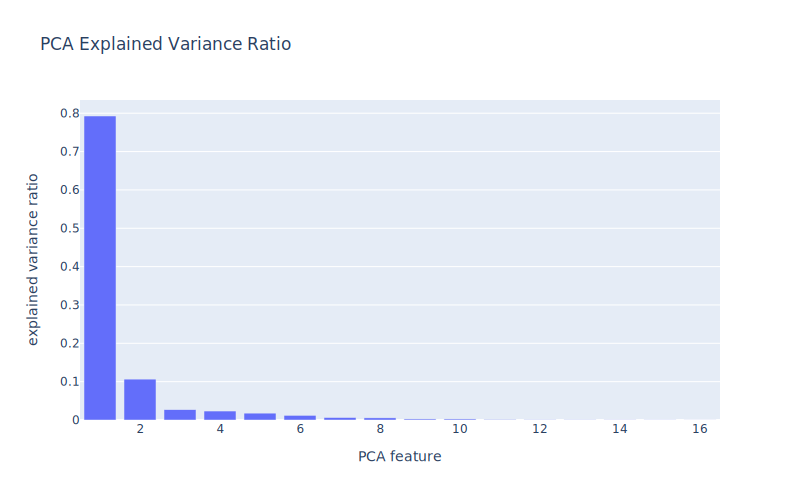

In [63]:
pca_df = pd.DataFrame(data={"explained variance ratio": my_pca.explained_variance_ratio_,
                            "PCA feature": np.linspace(1, 16, 16)})

pca_fig = px.bar(pca_df, x="PCA feature", y="explained variance ratio", title="PCA Explained Variance Ratio")

pca_fig.show("svg", width=800, height=500)

**K-Nearest Neighbours Regression Approach**

Interesting concepts to look into:
    - Neighbourhood components analysis
    - Large margin nearest neighbor
    - Mahalanobis distance
    - Sparse PCA
